### 코드 구성
- ### ResNet - CIFAR10 dateset
    - ResNet34 residual, ResNet50 residual
    - ResNet34 plain, ResNet50 plain
    - 그래프 비교
    - Confusion matrice

- ### ResNet - TensorFlow dateset
    - ResNet34 residual, ResNet50 residual
    - ResNet34 plain, ResNet50 plain
    - 그래프 비교
    - Confusion matrice

- ### VGG16 & VGG18

각 과정을 별도로 실행할 수 있도록 패키지 선언을 구성에 맞게 선언하였다.

### ResNet - CIFAR10 dateset



In [1]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.model_selection import train_test_split

# Helper libraries
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


In [2]:
BATCH_SIZE = 64
EPOCH = 15
current_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()


In [3]:
def set_seed(seed=42):
    # 1. 기본 파이썬 및 넘파이 시드 고정
    random.seed(seed)
    np.random.seed(seed)

    # 2. 파이토치 CPU 및 GPU 시드 고정
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # 멀티 GPU 사용 시 필수

    # 3. CuDNN 알고리즘 고정 (재현성을 위한 핵심)
    # 연산 속도가 약간 느려질 수 있지만, 결과는 일정해집니다.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
g = torch.Generator()
g.manual_seed(42)

## 데이터셋 구축 및 계층적 분할 검증

In [ ]:
def get_stratified_cifar10(total_samples=10000, train_ratio=0.8, batch_size=32, num_workers=2):
    """
    CIFAR-10 데이터셋을 지정된 개수만큼 클래스 비율에 맞춰 추출하고 분할합니다.
    
    Args:
        total_samples (int): 전체 60,000개 중 사용할 데이터 총합
        train_ratio (float): total_samples 중 학습 데이터가 차지할 비율 (0.0 ~ 1.0)
        batch_size (int): 배치 사이즈
        num_workers (int): 데이터 로딩에 사용할 프로세스 수
    """
    
    # 1. Transform 정의
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # 2. 전체 데이터셋 로드 (학습용+테스트용 합치기)
    full_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    full_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    full_dataset = ConcatDataset([full_train, full_test])
    
    # 3. 모든 데이터의 라벨(targets) 추출
    all_labels = np.array(full_train.targets + full_test.targets)
    indices = np.arange(len(all_labels))

    # 4. 단계 1: 전체에서 원하는 total_samples만큼 클래스 비율에 맞춰 랜덤 추출
    selected_indices, _ = train_test_split(
        indices, 
        train_size=total_samples, 
        stratify=all_labels, 
        random_state=42, # 결과 재현을 위한 시드
        shuffle=True
    )
    
    # 선택된 인덱스들의 라벨 정보 추출
    selected_labels = all_labels[selected_indices]

    # 5. 단계 2: 선택된 데이터 내에서 학습용/테스트용으로 분할
    train_idx, test_idx = train_test_split(
        selected_indices, 
        train_size=train_ratio, 
        stratify=selected_labels, 
        random_state=42,
        shuffle=True
    )

    # 6. Subset을 이용한 데이터셋 생성
    train_set = Subset(full_dataset, train_idx)
    test_set = Subset(full_dataset, test_idx)

    classes = full_train.classes 
    train_set.classes = classes
    test_set.classes = classes

    # 7. DataLoader 생성
    train_loader = DataLoader(
        train_set, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers
    )
    
    test_loader = DataLoader(
        test_set, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers
    )

    print(f"--- 데이터셋 구성 완료 ---")
    print(f"전체 사용 데이터: {len(selected_indices)}개")
    print(f"학습 데이터: {len(train_set)}개 (비율: {train_ratio})")
    print(f"테스트 데이터: {len(test_set)}개 (나머지)")
    
    return train_set, test_set, train_loader, test_loader, all_labels

In [6]:
trainset, testset, trainloader, testloader, labels = get_stratified_cifar10(total_samples=20000, train_ratio=0.8, batch_size = BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
--- 데이터셋 구성 완료 ---
전체 사용 데이터: 20000개
학습 데이터: 16000개 (비율: 0.8)
테스트 데이터: 4000개 (나머지)


In [7]:
# 데이터셋을 로드하고 기본 정보를 확인해 보세요.
image, _ = trainset[0]

print(f"Image shape: {image.shape}")

Image shape: torch.Size([3, 224, 224])


In [8]:
def print_subset_dist(subset, labels, title="Dataset"):
    # Subset이 가진 인덱스들을 이용해 해당 라벨들만 추출
    subset_labels = labels[subset.indices]
    counts = Counter(subset_labels)
    class_names = subset.classes
    
    
    print(f"\n=== {title} Distribution ===")
    # 클래스 이름 순서대로 출력
    print(class_names)
    for i, name in enumerate(subset.classes):
        print(f"{name:12}: {counts[i]} samples")

# 3. 실행
print_subset_dist(trainset, labels, "Train Set")
print_subset_dist(testset, labels, "Test Set")


=== Train Set Distribution ===
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
airplane    : 1600 samples
automobile  : 1600 samples
bird        : 1600 samples
cat         : 1600 samples
deer        : 1600 samples
dog         : 1600 samples
frog        : 1600 samples
horse       : 1600 samples
ship        : 1600 samples
truck       : 1600 samples

=== Test Set Distribution ===
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
airplane    : 400 samples
automobile  : 400 samples
bird        : 400 samples
cat         : 400 samples
deer        : 400 samples
dog         : 400 samples
frog        : 400 samples
horse       : 400 samples
ship        : 400 samples
truck       : 400 samples


## 데이터 샘플 시각화 및 검토

In [9]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))


In [10]:
def show_multiple_images(dataset, n_images=9):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    axes = axes.flatten()

    for i in range(n_images):
        ax = axes[i]
        img = imshow(images[i])
        ax.imshow(img)
        ax.set_title(f"Label: {trainset.classes[labels[i]]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49901533..1.7938564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.584706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42195398..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44764107..1.3406973].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5161401..1.8025708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5247024..0.68710244].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952.

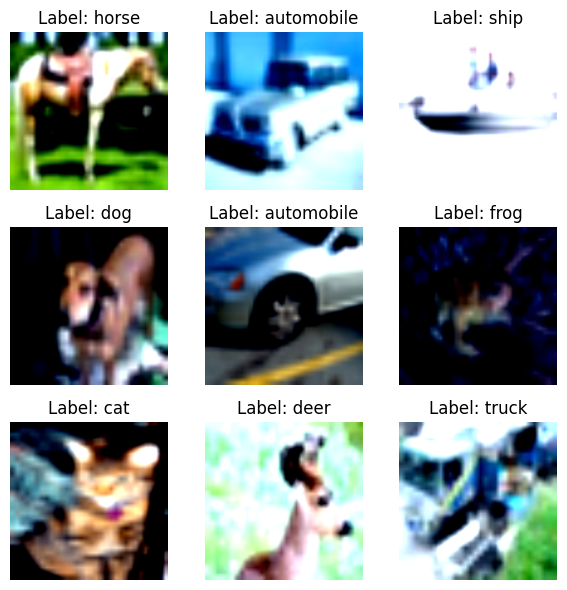

In [11]:
# 학습 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(trainloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32776785..0.82653606].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..0.9908383].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44782913..1.453987].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47408962..1.7677125].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48189062..1.6195644].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1822074..

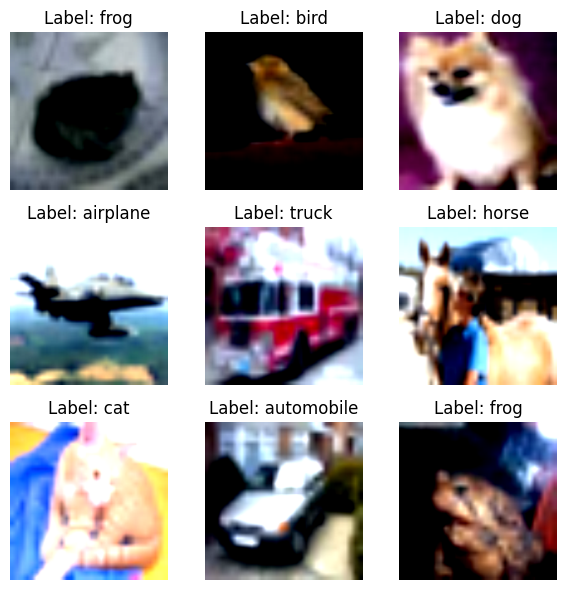

In [12]:
# 테스트 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(testloader)

## ResNet 모델 아키텍처 설계 및 정의

In [13]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, is_skip = True):
        super().__init__()
        self.is_skip = is_skip
        self.conv1 = nn.Conv2d(
            inplanes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.is_skip:
            out += self.shortcut(x)
        out = self.relu(out)
        return out

In [14]:
class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, is_skip = True):
        super().__init__()
        self.is_skip = is_skip
        self.conv1 = nn.Conv2d(
            inplanes, planes,
            kernel_size=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion*planes,
            kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.is_skip:
            out += self.shortcut(x)

        out = self.relu(out)
        return out

In [15]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000,is_skip = True):
        super().__init__()

        self.inplanes = 64
        self.stem = nn.Sequential(
            nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.inplanes),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.stage1 = self._make_layer(block, 64, layers[0], stride=1, is_skip = is_skip)
        self.stage2 = self._make_layer(block, 128, layers[1], stride=2, is_skip = is_skip)
        self.stage3 = self._make_layer(block, 256, layers[2], stride=2, is_skip = is_skip)
        self.stage4 = self._make_layer(block, 512, layers[3], stride=2, is_skip = is_skip)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, is_skip):
      layers = []
      layers.append(block(self.inplanes, planes, stride, is_skip=is_skip))

      self.inplanes = planes * block.expansion
      for _ in range(num_blocks - 1):
          layers.append(block(self.inplanes, planes, 1, is_skip=is_skip))

      return nn.Sequential(*layers)

    def forward(self, x):
        out = self.stem(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

## 학습 및 검증 프로세스의 모듈화 설계

In [16]:
def evaluate(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [17]:
def train_model(model, trainloader, testloader, criterion, optimizer, device, epochs, save_path):
    train_losses = []
    val_accuracies = []

    start_time = time.time() # 전체 학습 시작 시간 측정
    print(f"Training started on {device}...")

    for epoch in range(epochs):
        # 학습 모드
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 50 == 49:
                print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i + 1):.3f}")

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)

        val_acc = evaluate(model, testloader, device)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    end_time = time.time()
    print("Finished Training")
    print(f"Total training time: {end_time - start_time:.2f} seconds")

    # 모델의 가중치(weights)만 저장하는 방식 (권장)
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

    return train_losses, val_accuracies

## 모델별 동적 저장 경로 설정

In [18]:
save_dir = "./models/"
os.makedirs(save_dir, exist_ok=True)

In [19]:
def modelSavePath(save_dir, model_name, is_skip = True):
    if is_skip == True:
        model_mode = "residual"
    else:
        model_mode = "plain"  
    
    file_name = f"{model_name}_{model_mode}.pth"
    save_path = os.path.join(save_dir, file_name)

    return save_path

---

In [20]:
# ResNet: residual block
is_skip =  True

## ResNet34: residual 학습

In [21]:
set_seed(42)

In [22]:
model_name = "resnet34"  
save_path = modelSavePath(save_dir, model_name, is_skip)

In [23]:
resnet34 = ResNet(BasicBlock, [3, 4, 6, 3], 10, is_skip = is_skip ).to(device)

In [24]:
# resnet34 아키텍처 시각화
resnet34

ResNet(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (stage1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [25]:
optimizer = optim.SGD(resnet34.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [26]:
resnet34_train_losses, resnet34_val_accs = train_model(
    resnet34, trainloader, testloader, criterion, optimizer, device, epochs=EPOCH, save_path = save_path 
)

Training started on cuda...
[1,    50] loss: 2.066
[1,   100] loss: 1.915
[1,   150] loss: 1.838
[1,   200] loss: 1.777
[1,   250] loss: 1.724
Epoch 1: Train Acc: 35.54%, Val Acc: 45.67%
[2,    50] loss: 1.445
[2,   100] loss: 1.437
[2,   150] loss: 1.404
[2,   200] loss: 1.389
[2,   250] loss: 1.369
Epoch 2: Train Acc: 49.88%, Val Acc: 53.30%
[3,    50] loss: 1.200
[3,   100] loss: 1.183
[3,   150] loss: 1.172
[3,   200] loss: 1.155
[3,   250] loss: 1.137
Epoch 3: Train Acc: 59.51%, Val Acc: 57.60%
[4,    50] loss: 0.935
[4,   100] loss: 0.952
[4,   150] loss: 0.936
[4,   200] loss: 0.933
[4,   250] loss: 0.923
Epoch 4: Train Acc: 67.26%, Val Acc: 59.95%
[5,    50] loss: 0.712
[5,   100] loss: 0.720
[5,   150] loss: 0.725
[5,   200] loss: 0.729
[5,   250] loss: 0.734
Epoch 5: Train Acc: 73.91%, Val Acc: 61.83%
[6,    50] loss: 0.506
[6,   100] loss: 0.498
[6,   150] loss: 0.503
[6,   200] loss: 0.524
[6,   250] loss: 0.543
Epoch 6: Train Acc: 81.26%, Val Acc: 65.00%
[7,    50] loss: 0

## ResNet50: residual 학습

In [27]:
set_seed(42)

In [28]:
model_name = "resnet50"  
save_path = modelSavePath(save_dir, model_name, is_skip)

In [29]:
resnet50 = ResNet(BottleneckBlock, [3, 4, 6, 3], 10,is_skip = is_skip).to(device)

In [30]:
# resnet50 아키텍처 시각화
resnet50

ResNet(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (stage1): Sequential(
    (0): BottleneckBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_si

In [31]:
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [32]:
resnet50_train_losses, resnet50_val_accs = train_model(
    resnet50, trainloader, testloader, criterion, optimizer, device, epochs=EPOCH, save_path = save_path 
)

Training started on cuda...
[1,    50] loss: 2.348
[1,   100] loss: 2.217
[1,   150] loss: 2.147
[1,   200] loss: 2.076
[1,   250] loss: 2.015
Epoch 1: Train Acc: 25.57%, Val Acc: 33.75%
[2,    50] loss: 1.718
[2,   100] loss: 1.696
[2,   150] loss: 1.675
[2,   200] loss: 1.654
[2,   250] loss: 1.629
Epoch 2: Train Acc: 39.31%, Val Acc: 44.12%
[3,    50] loss: 1.508
[3,   100] loss: 1.478
[3,   150] loss: 1.488
[3,   200] loss: 1.472
[3,   250] loss: 1.469
Epoch 3: Train Acc: 46.09%, Val Acc: 48.27%
[4,    50] loss: 1.332
[4,   100] loss: 1.355
[4,   150] loss: 1.338
[4,   200] loss: 1.324
[4,   250] loss: 1.327
Epoch 4: Train Acc: 51.74%, Val Acc: 50.70%
[5,    50] loss: 1.222
[5,   100] loss: 1.195
[5,   150] loss: 1.196
[5,   200] loss: 1.199
[5,   250] loss: 1.192
Epoch 5: Train Acc: 56.87%, Val Acc: 54.70%
[6,    50] loss: 1.094
[6,   100] loss: 1.072
[6,   150] loss: 1.081
[6,   200] loss: 1.082
[6,   250] loss: 1.084
Epoch 6: Train Acc: 61.36%, Val Acc: 59.17%
[7,    50] loss: 0

In [ ]:
# Residual 레이어 확인
print(resnet50.stage1[0].shortcut[0].weight.grad)

tensor([[[[-1.2762e-03]],

         [[-9.7102e-04]],

         [[-1.5814e-03]],

         ...,

         [[ 2.4836e-03]],

         [[ 1.7400e-03]],

         [[ 4.5420e-03]]],


        [[[-4.1490e-04]],

         [[ 8.6539e-04]],

         [[-7.6545e-04]],

         ...,

         [[-2.7420e-03]],

         [[-1.6291e-03]],

         [[-2.4478e-03]]],


        [[[-3.2025e-03]],

         [[-5.0675e-03]],

         [[-2.7373e-03]],

         ...,

         [[-1.1628e-03]],

         [[-1.2042e-03]],

         [[-3.0186e-04]]],


        ...,


        [[[ 1.7631e-03]],

         [[-1.5645e-03]],

         [[ 2.3347e-03]],

         ...,

         [[ 2.1007e-03]],

         [[ 2.1400e-03]],

         [[ 1.1291e-03]]],


        [[[ 1.3888e-03]],

         [[ 2.0149e-03]],

         [[ 4.6041e-05]],

         ...,

         [[ 1.0290e-03]],

         [[-1.8903e-05]],

         [[ 2.9814e-03]]],


        [[[ 2.9653e-04]],

         [[-1.1368e-03]],

         [[ 7.7837e-04]],

         

### ResNet | Residual 실험 결과 시각화 및 성능 비교 분석

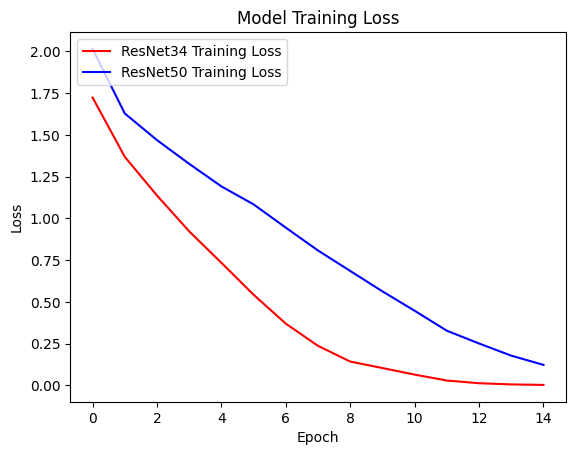

In [34]:
plt.plot(resnet34_train_losses, 'r', label="ResNet34 Training Loss")
plt.plot(resnet50_train_losses, 'b', label="ResNet50 Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

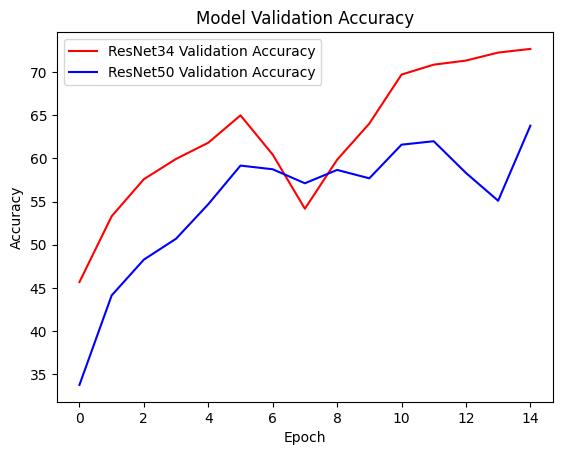

In [35]:
plt.plot(resnet34_val_accs, 'r', label="ResNet34 Validation Accuracy")
plt.plot(resnet50_val_accs, 'b', label="ResNet50 Validation Accuracy")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

#### 그래프 분석
ResNet34, ResNet50의 Traininmg Loss 그래프를 비교해보면 이론상 ResNet50의 Traininmg Loss가 더 낮은 모습을 보여야 한다.
ResNet34, ResNet50의 Validation Accuracy 그래프를 비교해보면 이론상 ResNet50의 Validation Accuracy가 더 높은 모습을 보여야 한다.
>  하지만 실제 그래프를 보면 그렇지 않은 것을 볼 수 있다  

이와 같은 결과가 나온 이유를 추측해보면
1. 충분하지 않은 학습량(15 epoch)으로 충분한 학습을 이루지 못함
    - 그 증거로 train acc는 100%에 근접했지만 val acc는 그러지 못한 것을 확인할 수 있음
2. 데이터셋의 결정적인 결함
  - CIFAR10 데이터를 활용하고, 학습 시간 단축을 위해 전체 데이터에서 20000개를 학습 데이터와 검증 데이터로 분리했다(적은 dataset)
  - CIFAR10 데이터를 32x32x3의 shape을 가지고 있다. 그렇기 때문에 CIFAR10 데이터를 그대로 ResNet에 입력으로 주면 합성곱 연산 과정에서 이미지가 소실되는 문제가 발생할 수 있다.   
    따라서 32x32를 224x224로 resize를 한 후 모델의 입력으로 주고 있다.
  - 또한 CIFAR10의 클래스는 10개이며 이를 전체데이터를 20000개로 축소하고 학습용과 검증용으로 나누었다(0.8:0.2)  
    그렇기 때문에 각 클래스의 학습용 이미지는 1600개이다 모델이 학습하기에는 적은 수이다.

이러한 요인으로 ResNet34, ResNet50의 모델 성능이 이론적으로 좋게 나오지 못한 것으로 추측됨

---

In [36]:
# ResNet: plain block
is_skip =  False

## ResNet34: Plain 학습

In [37]:
set_seed(42)

In [38]:
model_name = "resnet34"  
save_path = modelSavePath(save_dir, model_name, is_skip)

In [39]:
resnet34_Plain = ResNet(BasicBlock, [3, 4, 6, 3], 10, is_skip = is_skip ).to(device)

In [40]:
optimizer = optim.SGD(resnet34_Plain.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [41]:
resnet34_Plain_train_losses, resnet34_Plain_val_accs = train_model(
    resnet34_Plain, trainloader, testloader, criterion, optimizer, device, epochs=EPOCH, save_path = save_path 
)

Training started on cuda...
[1,    50] loss: 2.299
[1,   100] loss: 2.242
[1,   150] loss: 2.163
[1,   200] loss: 2.083
[1,   250] loss: 2.020
Epoch 1: Train Acc: 24.08%, Val Acc: 32.90%
[2,    50] loss: 1.750
[2,   100] loss: 1.728
[2,   150] loss: 1.699
[2,   200] loss: 1.685
[2,   250] loss: 1.672
Epoch 2: Train Acc: 37.65%, Val Acc: 41.08%
[3,    50] loss: 1.554
[3,   100] loss: 1.543
[3,   150] loss: 1.529
[3,   200] loss: 1.518
[3,   250] loss: 1.512
Epoch 3: Train Acc: 44.12%, Val Acc: 47.20%
[4,    50] loss: 1.421
[4,   100] loss: 1.403
[4,   150] loss: 1.392
[4,   200] loss: 1.388
[4,   250] loss: 1.378
Epoch 4: Train Acc: 49.54%, Val Acc: 53.42%
[5,    50] loss: 1.259
[5,   100] loss: 1.261
[5,   150] loss: 1.253
[5,   200] loss: 1.250
[5,   250] loss: 1.249
Epoch 5: Train Acc: 54.87%, Val Acc: 54.83%
[6,    50] loss: 1.115
[6,   100] loss: 1.129
[6,   150] loss: 1.131
[6,   200] loss: 1.132
[6,   250] loss: 1.131
Epoch 6: Train Acc: 59.67%, Val Acc: 56.98%
[7,    50] loss: 0

## ResNet50: Prain 학습

In [42]:
set_seed(42)

In [43]:
model_name = "resnet50"  
save_path = modelSavePath(save_dir, model_name, is_skip)

In [44]:
resnet50_Plain = ResNet(BottleneckBlock, [3, 4, 6, 3], 10,is_skip = is_skip).to(device)

In [45]:
optimizer = optim.SGD(resnet50_Plain.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [46]:
resnet50_Plain_train_losses, resnet50_Plain_val_accs = train_model(
    resnet50_Plain, trainloader, testloader, criterion, optimizer, device, epochs=EPOCH, save_path = save_path 
)

Training started on cuda...
[1,    50] loss: 2.304
[1,   100] loss: 2.290
[1,   150] loss: 2.277
[1,   200] loss: 2.241
[1,   250] loss: 2.197
Epoch 1: Train Acc: 16.11%, Val Acc: 23.48%
[2,    50] loss: 1.929
[2,   100] loss: 1.904
[2,   150] loss: 1.892
[2,   200] loss: 1.877
[2,   250] loss: 1.858
Epoch 2: Train Acc: 29.69%, Val Acc: 33.38%
[3,    50] loss: 1.732
[3,   100] loss: 1.709
[3,   150] loss: 1.703
[3,   200] loss: 1.691
[3,   250] loss: 1.683
Epoch 3: Train Acc: 37.02%, Val Acc: 39.62%
[4,    50] loss: 1.612
[4,   100] loss: 1.611
[4,   150] loss: 1.600
[4,   200] loss: 1.585
[4,   250] loss: 1.581
Epoch 4: Train Acc: 41.31%, Val Acc: 40.77%
[5,    50] loss: 1.541
[5,   100] loss: 1.519
[5,   150] loss: 1.514
[5,   200] loss: 1.518
[5,   250] loss: 1.508
Epoch 5: Train Acc: 44.32%, Val Acc: 44.52%
[6,    50] loss: 1.466
[6,   100] loss: 1.440
[6,   150] loss: 1.443
[6,   200] loss: 1.443
[6,   250] loss: 1.439
Epoch 6: Train Acc: 47.37%, Val Acc: 46.98%
[7,    50] loss: 1

In [ ]:
# Residual 레이어 확인
print(resnet50.stage1[0].shortcut[0].weight.grad)

None


### ResNet | Plain 실험 결과 시각화 및 성능 비교 분석

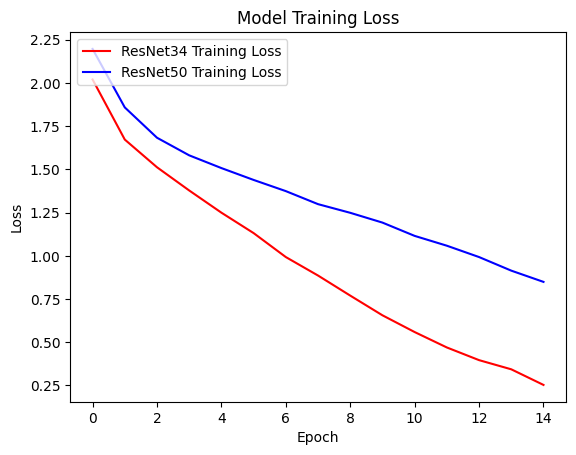

In [48]:
plt.plot(resnet34_Plain_train_losses, 'r', label="ResNet34 Training Loss")
plt.plot(resnet50_Plain_train_losses, 'b', label="ResNet50 Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

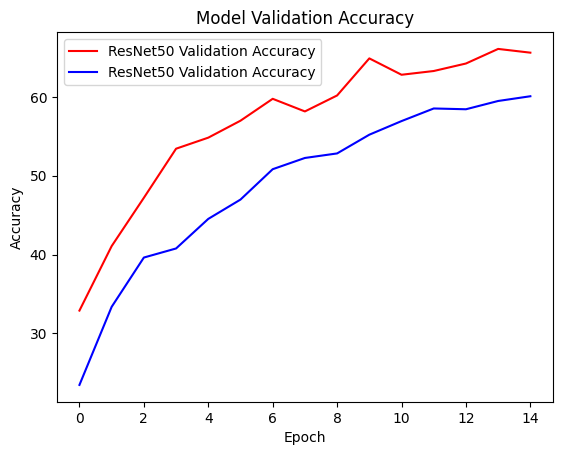

In [ ]:
plt.plot(resnet34_Plain_val_accs, 'r', label="ResNet34 Validation Accuracy")
plt.plot(resnet50_Plain_val_accs, 'b', label="ResNet50 Validation Accuracy")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

#### 그래프 분석
>ResNet34 Plain, ResNet50 Plain의 모델의 그래프를 보면 알 수 있는 점은 레이어가 깊어질수록 Residual block 없이 모델을 학습하면 기울기 저하 문제를 확인할 수 있다.

### ResNet | Residual&Plain 실험 결과 시각화 및 성능 비교 분석

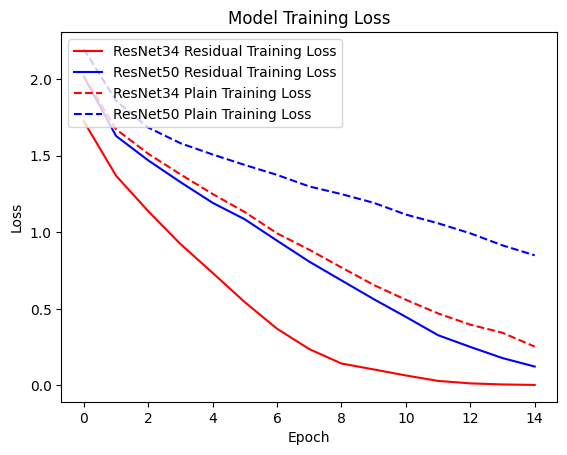

In [ ]:
plt.plot(resnet34_train_losses, 'r', label="ResNet34 Residual Training Loss")
plt.plot(resnet50_train_losses, 'b', label="ResNet50 Residual Training Loss")
plt.plot(resnet34_Plain_train_losses, 'r--', label="ResNet34 Plain Training Loss")
plt.plot(resnet50_Plain_train_losses, 'b--', label="ResNet50 Plain Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

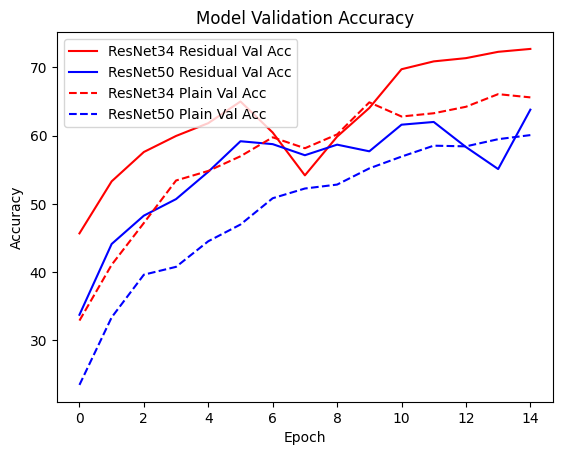

In [51]:
plt.plot(resnet34_val_accs, 'r', label="ResNet34 Residual Val Acc")
plt.plot(resnet50_val_accs, 'b', label="ResNet50 Residual Val Acc")
plt.plot(resnet34_Plain_val_accs, 'r--', label="ResNet34 Plain Val Acc")
plt.plot(resnet50_Plain_val_accs, 'b--', label="ResNet50 Plain Val Acc")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

## 그래프 분석
위와 같은 그래프로 같은 레이어의 Residual block을 통해 학습한 경우가 Training Loss가 더 낮게 수렴하고 Validation Accuracy가 높은 것을 알 수 있다.

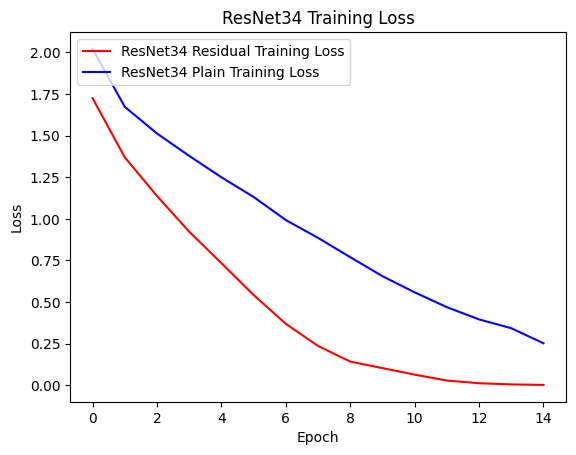

In [52]:
plt.plot(resnet34_train_losses, 'r', label="ResNet34 Residual Training Loss")
plt.plot(resnet34_Plain_train_losses, 'b', label="ResNet34 Plain Training Loss")

plt.title('ResNet34 Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

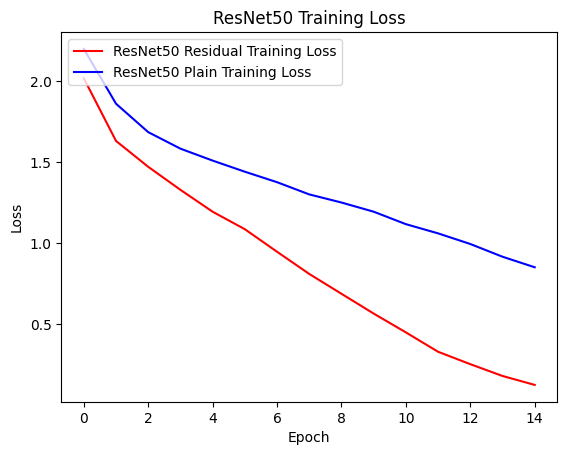

In [53]:
plt.plot(resnet50_train_losses, 'r', label="ResNet50 Residual Training Loss")
plt.plot(resnet50_Plain_train_losses, 'b', label="ResNet50 Plain Training Loss")

plt.title('ResNet50 Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

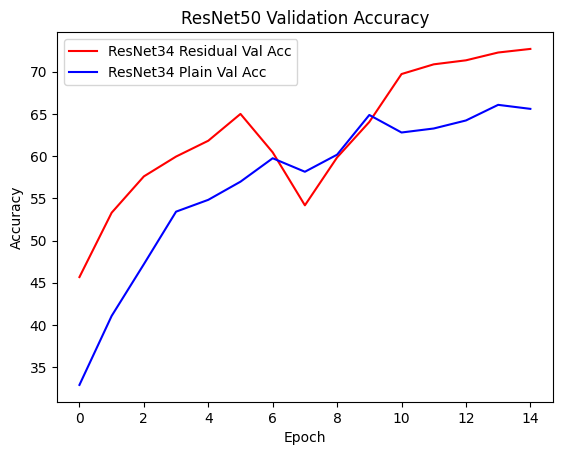

In [54]:
plt.plot(resnet34_val_accs, 'r', label="ResNet34 Residual Val Acc")
plt.plot(resnet34_Plain_val_accs, 'b', label="ResNet34 Plain Val Acc")

plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

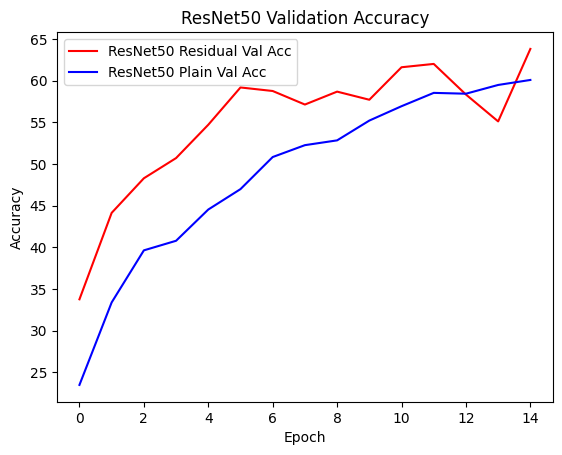

In [55]:
plt.plot(resnet50_val_accs, 'r', label="ResNet50 Residual Val Acc")
plt.plot(resnet50_Plain_val_accs, 'b', label="ResNet50 Plain Val Acc")

plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

#### 그래프 분석
epoch(15)이 적게 설정하고 학습한 모델이기 때문에 차이가 명확하지 않을 수 있으나  
Training Loss 그래프를 보면 Residual block을 유무가 영향을 주고 있다는 것을 볼 수 있다  
Validation Accuracy 그래프를 보면 비슷해보일 수 있으나 이는 4개 모델 모두 학습이 충분히 이루어지지 않은것으로 확실한 비교는 어렵다.

## Confusion matrice

In [56]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns

def run_final_evaluation(model, testloader, device, classes):
    # 1. 평가 모드 전환
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []

    print("데이터 검증 중...")
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 모델 예측 (에러 방지를 위해 인스턴스 호출)
            outputs = model(inputs)
            
            # 확률값(ROC-AUC용) 및 예측값(Confusion Matrix용) 추출
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # --- [결과 출력 1] Classification Report (Precision, Recall, F1) ---
    print("\n" + "="*50)
    print("1. 분류 상세 리포트")
    print("="*50)
    print(classification_report(all_labels, all_preds, target_names=classes))

    # --- [결과 출력 2] ROC-AUC Score ---
    auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    print(f"2. ROC-AUC Score (Overall): {auc:.4f}")

    # --- [결과 출력 3] Confusion Matrix 시각화 ---
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

C:\Users\pe020\AppData\Local\Temp\ipykernel_6692\4284939302.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet34.load_state_dict(torch.load('./models/resnet34_residu

데이터 검증 중...

1. 분류 상세 리포트
              precision    recall  f1-score   support

    airplane       0.77      0.75      0.76       400
  automobile       0.84      0.90      0.87       400
        bird       0.67      0.57      0.62       400
         cat       0.51      0.55      0.53       400
        deer       0.66      0.65      0.65       400
         dog       0.62      0.58      0.60       400
        frog       0.77      0.79      0.78       400
       horse       0.77      0.72      0.74       400
        ship       0.80      0.89      0.84       400
       truck       0.85      0.88      0.86       400

    accuracy                           0.73      4000
   macro avg       0.73      0.73      0.73      4000
weighted avg       0.73      0.73      0.73      4000

2. ROC-AUC Score (Overall): 0.9583


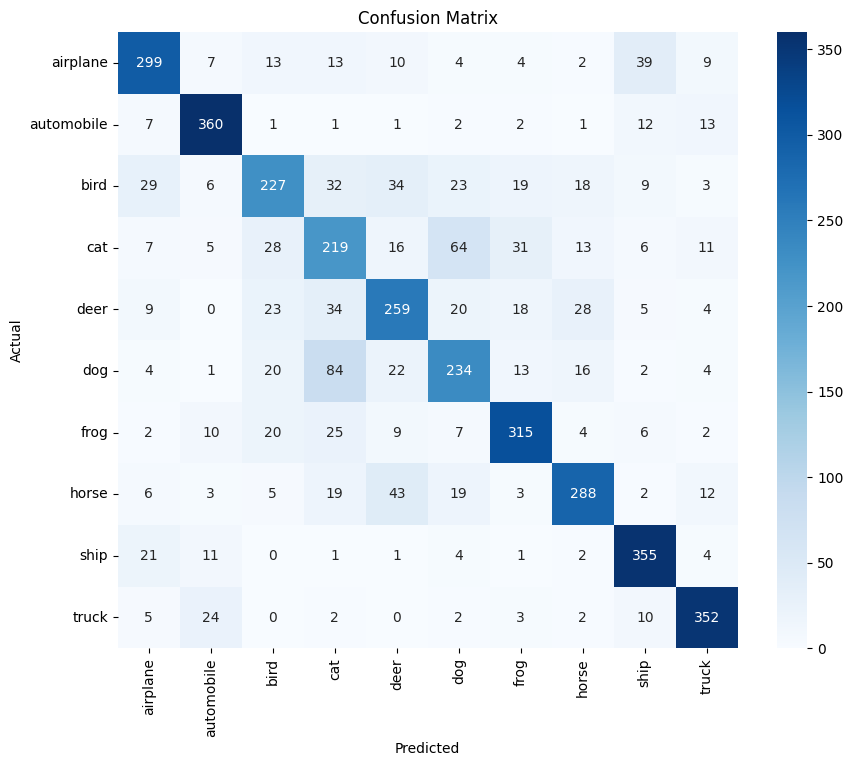

In [57]:
resnet34.load_state_dict(torch.load('./models/resnet34_residual.pth', map_location=device))
resnet34.to(device)

run_final_evaluation(resnet34, testloader, device,testset.classes)

C:\Users\pe020\AppData\Local\Temp\ipykernel_6692\62917204.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet50.load_state_dict(torch.load('./models/resnet50_residual

데이터 검증 중...

1. 분류 상세 리포트
              precision    recall  f1-score   support

    airplane       0.65      0.77      0.70       400
  automobile       0.61      0.94      0.74       400
        bird       0.67      0.46      0.54       400
         cat       0.57      0.31      0.40       400
        deer       0.48      0.60      0.53       400
         dog       0.54      0.61      0.57       400
        frog       0.83      0.61      0.70       400
       horse       0.60      0.76      0.67       400
        ship       0.82      0.69      0.75       400
       truck       0.77      0.64      0.70       400

    accuracy                           0.64      4000
   macro avg       0.65      0.64      0.63      4000
weighted avg       0.65      0.64      0.63      4000

2. ROC-AUC Score (Overall): 0.9356


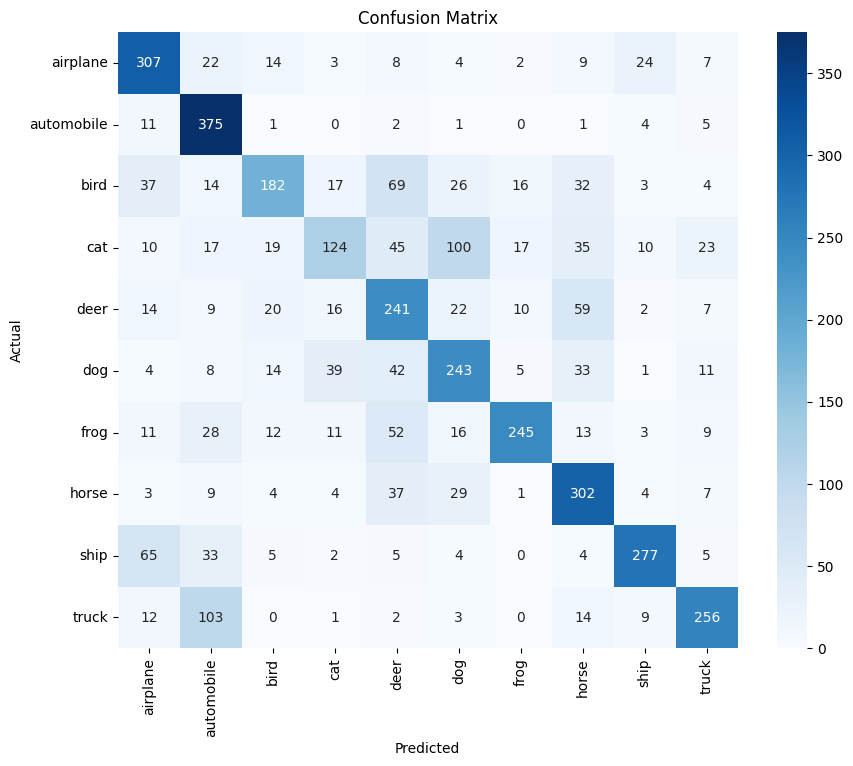

In [58]:
resnet50.load_state_dict(torch.load('./models/resnet50_residual.pth', map_location=device))
resnet50.to(device)

run_final_evaluation(resnet50, testloader, device, testset.classes)

C:\Users\pe020\AppData\Local\Temp\ipykernel_6692\1348496537.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet34_Plain.load_state_dict(torch.load('./models/resnet34_

데이터 검증 중...

1. 분류 상세 리포트
              precision    recall  f1-score   support

    airplane       0.77      0.65      0.71       400
  automobile       0.95      0.66      0.78       400
        bird       0.45      0.74      0.56       400
         cat       0.48      0.42      0.45       400
        deer       0.56      0.57      0.56       400
         dog       0.63      0.53      0.57       400
        frog       0.65      0.81      0.73       400
       horse       0.76      0.55      0.64       400
        ship       0.85      0.74      0.79       400
       truck       0.72      0.88      0.79       400

    accuracy                           0.66      4000
   macro avg       0.68      0.66      0.66      4000
weighted avg       0.68      0.66      0.66      4000

2. ROC-AUC Score (Overall): 0.9404


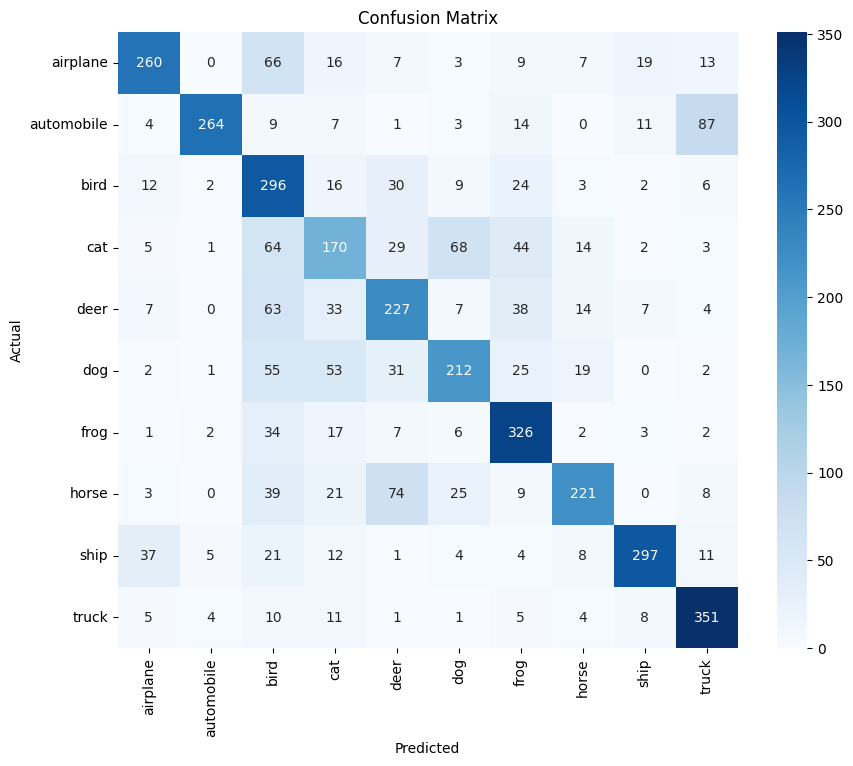

In [59]:
resnet34_Plain.load_state_dict(torch.load('./models/resnet34_plain.pth', map_location=device))
resnet34_Plain.to(device)

run_final_evaluation(resnet34_Plain, testloader, device, testset.classes)

C:\Users\pe020\AppData\Local\Temp\ipykernel_6692\3712858381.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet50_Plain.load_state_dict(torch.load('./models/resnet50_

데이터 검증 중...

1. 분류 상세 리포트
              precision    recall  f1-score   support

    airplane       0.70      0.66      0.68       400
  automobile       0.78      0.67      0.72       400
        bird       0.62      0.34      0.44       400
         cat       0.45      0.44      0.44       400
        deer       0.54      0.50      0.52       400
         dog       0.45      0.55      0.49       400
        frog       0.73      0.59      0.65       400
       horse       0.57      0.72      0.63       400
        ship       0.74      0.73      0.74       400
       truck       0.56      0.81      0.66       400

    accuracy                           0.60      4000
   macro avg       0.61      0.60      0.60      4000
weighted avg       0.61      0.60      0.60      4000

2. ROC-AUC Score (Overall): 0.9235


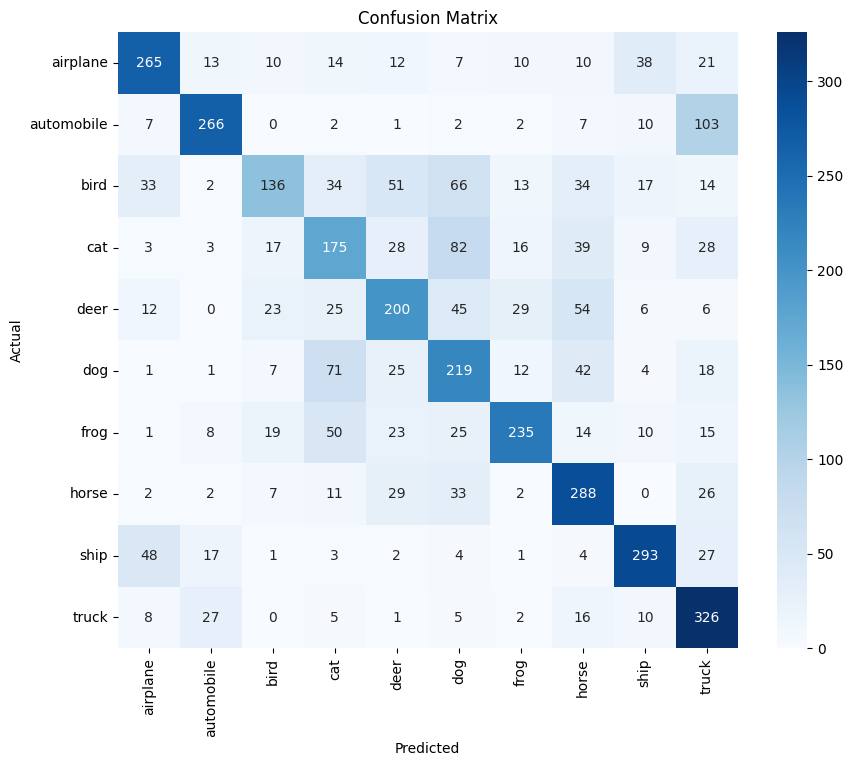

In [60]:
resnet50_Plain.load_state_dict(torch.load('./models/resnet50_plain.pth', map_location=device))
resnet50_Plain.to(device)

run_final_evaluation(resnet50_Plain, testloader, device, testset.classes)

## 회고
epoch을 많이 늘려 모델을 학습시키지 못한 것이 아쉽지만 
ResNet의 중요 개념이 residual block이 모델에 영향을 주는 가에 대한 실험을 통해  
dataset의 중요성을 알게 되었고 모델의 학습에 있어 적절한 하이퍼 파라미터 튜닝이 어렵다는 것을 알게 되었다.

# ResNet - TensorFlow dataset

- ### CIFAR-10 dataset이 아닌 tensorflow의 cat vs dogs dataset을 활용해 전체 데이터를 10000개로 제한하고  
  ### 학습용 데이터와 실습용 데이터를 0.8:0.2 비율로 학습한 결과이다

In [61]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# Dataset download
import os
import zipfile
import urllib.request
from PIL import Image
from collections import Counter

# Helper libraries
import random
import numpy as np
import matplotlib.pyplot as plt
import time

In [62]:
import ssl

# SSL 인증서 확인 과정을 생략하도록 설정
ssl._create_default_https_context = ssl._create_unverified_context

In [63]:
def set_seed(seed=22):
    # 1. 기본 파이썬 및 넘파이 시드 고정
    random.seed(seed)
    np.random.seed(seed)

    # 2. 파이토치 CPU 및 GPU 시드 고정
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # 멀티 GPU 사용 시 필수

    # 3. CuDNN 알고리즘 고정 (재현성을 위한 핵심)
    # 연산 속도가 약간 느려질 수 있지만, 결과는 일정해집니다.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [64]:
set_seed(22)

In [65]:
g = torch.Generator()
g.manual_seed(22)

In [66]:
# --- [설정 및 상수] ---
DATA_URL = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
ZIP_PATH = "cats_and_dogs.zip"
EXTRACT_PATH = "cats_vs_dogs_data"
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCH = 15

current_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

# ResNet 표준 정규화 수치
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

In [67]:
# --- [함수 1: 데이터 다운로드 및 압축 해제] ---
def download_and_extract(url, zip_p, extract_p):
    if not os.path.exists(zip_p):
        print("데이터셋 다운로드 중...")
        urllib.request.urlretrieve(url, zip_p)
    if not os.path.exists(extract_p):
        print("압축 해제 중...")
        with zipfile.ZipFile(zip_p, 'r') as zip_ref:
            zip_ref.extractall(extract_p)
    print("데이터 준비 완료.")

In [68]:
# --- [함수 2: 손상된 이미지 제거] ---
def clean_dataset(root_path):
    print("손상된 이미지 확인 및 제거 중...")
    count = 0
    for subdir, dirs, files in os.walk(root_path):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                file_path = os.path.join(subdir, file)
                try:
                    img = Image.open(file_path)
                    img.verify()
                except (IOError, SyntaxError):
                    os.remove(file_path)
                    count += 1
    print(f"제거된 손상 이미지: {count}개")

In [69]:
# --- [함수 3: 1:1 균형 잡힌 데이터 분할] ---
def get_balanced_subsets(full_dataset, n_train_per_class, n_test_per_class):
    cat_indices = [i for i, label in enumerate(full_dataset.targets) if label == 0]
    dog_indices = [i for i, label in enumerate(full_dataset.targets) if label == 1]

    np.random.shuffle(cat_indices)
    np.random.shuffle(dog_indices)

    train_idx = cat_indices[:n_train_per_class] + dog_indices[:n_train_per_class]
    test_idx = cat_indices[n_train_per_class : n_train_per_class + n_test_per_class] + \
               dog_indices[n_train_per_class : n_train_per_class + n_test_per_class]

    return Subset(full_dataset, train_idx), Subset(full_dataset, test_idx)

In [70]:
# --- [함수 4: 분포 확인 및 시각화] ---
def check_dist(dataset, title, classes):
    labels = [dataset.dataset.targets[i] for i in dataset.indices]
    counts = Counter(labels)
    print(f"\n[{title}]")
    for i, name in enumerate(classes):
        print(f" - {name}: {counts[i]}개 ({(counts[i]/len(labels))*100:.1f}%)")

In [71]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    img = np.array(NORM_STD) * img + np.array(NORM_MEAN) # 정규화 해제
    img = np.clip(img, 0, 1)
    return img

In [72]:
def show_samples(loader, classes):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(3, 3, figsize=(7, 7))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(imshow(images[i]))
        ax.set_title(classes[labels[i]])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [73]:
# 1. 데이터 다운로드 및 환경 정리
download_and_extract(DATA_URL, ZIP_PATH, EXTRACT_PATH)
clean_dataset(os.path.join(EXTRACT_PATH, "PetImages"))

데이터 준비 완료.
손상된 이미지 확인 및 제거 중...


c:\Users\pe020\anaconda3\envs\ai_env\lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


제거된 손상 이미지: 0개


In [74]:
# 2. 전처리 정의
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(NORM_MEAN, NORM_STD)
])

In [75]:
# 3. 원본 데이터셋 로드
full_dataset = datasets.ImageFolder(root=os.path.join(EXTRACT_PATH, "PetImages"), transform=transform)

In [76]:
# 4. 1:1 균형 분할 (학습용 각 800개, 테스트용 각 200개 설정)
train_set, test_set = get_balanced_subsets(full_dataset, n_train_per_class=4000, n_test_per_class=1000)

In [77]:
# 5. 최종 DataLoader 생성
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)


[학습 데이터 분포]
 - Cat: 4000개 (50.0%)
 - Dog: 4000개 (50.0%)

[테스트 데이터 분포]
 - Cat: 1000개 (50.0%)
 - Dog: 1000개 (50.0%)


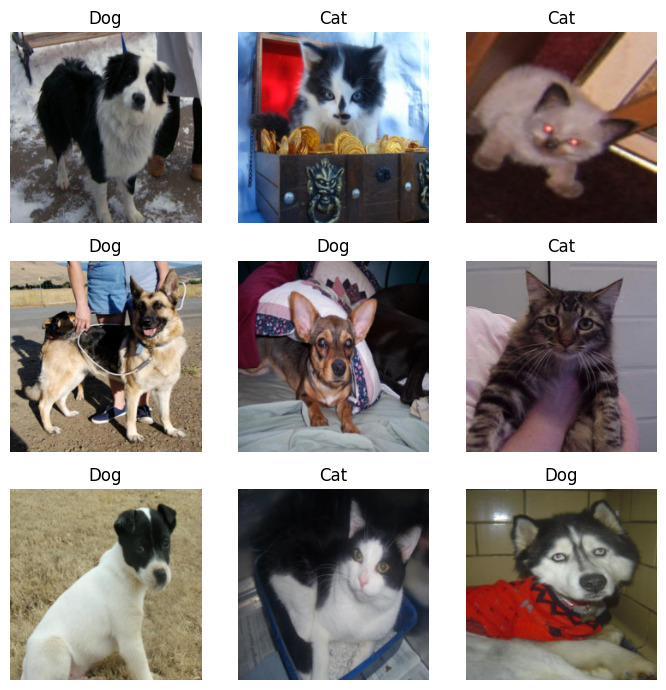

In [78]:
# 6. 결과 검증
check_dist(train_set, "학습 데이터 분포", full_dataset.classes)
check_dist(test_set, "테스트 데이터 분포", full_dataset.classes)
show_samples(trainloader, full_dataset.classes)

## ResNet 모델 아키텍처 설계 및 정의

In [79]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, is_skip = True):
        super().__init__()
        self.is_skip = is_skip
        self.conv1 = nn.Conv2d(
            inplanes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.is_skip:
            out += self.shortcut(x)
        out = self.relu(out)
        return out

In [80]:
class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, is_skip = True):
        super().__init__()
        self.is_skip = is_skip
        self.conv1 = nn.Conv2d(
            inplanes, planes,
            kernel_size=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion*planes,
            kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.is_skip:
            out += self.shortcut(x)

        out = self.relu(out)
        return out

In [81]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000,is_skip = True):
        super().__init__()

        self.inplanes = 64
        self.stem = nn.Sequential(
            nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.inplanes),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.stage1 = self._make_layer(block, 64, layers[0], stride=1, is_skip = is_skip)
        self.stage2 = self._make_layer(block, 128, layers[1], stride=2, is_skip = is_skip)
        self.stage3 = self._make_layer(block, 256, layers[2], stride=2, is_skip = is_skip)
        self.stage4 = self._make_layer(block, 512, layers[3], stride=2, is_skip = is_skip)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, is_skip):
      layers = []
      layers.append(block(self.inplanes, planes, stride, is_skip=is_skip))

      self.inplanes = planes * block.expansion
      for _ in range(num_blocks - 1):
          layers.append(block(self.inplanes, planes, 1, is_skip=is_skip))

      return nn.Sequential(*layers)

    def forward(self, x):
        out = self.stem(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

## 학습 및 검증 프로세스의 모듈화 설계

In [82]:
def evaluate(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [83]:
def train_model(model, trainloader, testloader, criterion, optimizer, device, epochs, save_path):
    train_losses = []
    val_accuracies = []

    start_time = time.time() # 전체 학습 시작 시간 측정
    print(f"Training started on {device}...")

    for epoch in range(epochs):
        # 학습 모드
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 50 == 49:
                print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i + 1):.3f}")

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)

        val_acc = evaluate(model, testloader, device)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    end_time = time.time()
    print("Finished Training")
    print(f"Total training time: {end_time - start_time:.2f} seconds")

    # 모델의 가중치(weights)만 저장하는 방식 (권장)
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

    return train_losses, val_accuracies

## 모델별 동적 저장 경로 설정

In [84]:
save_dir = "./models/"
os.makedirs(save_dir, exist_ok=True)

In [85]:
def modelSavePath(save_dir, model_name, is_skip = True):
    if is_skip == True:
        model_mode = "residual"
    else:
        model_mode = "plain"  
    
    file_name = f"{model_name}_{model_mode}.pth"
    save_path = os.path.join(save_dir, file_name)

    return save_path

---

In [86]:
# ResNet: residual block
is_skip =  True

## ResNet34: residual 학습

In [87]:
set_seed(22)

In [88]:
model_name = "resnet34_tf"  
save_path = modelSavePath(save_dir, model_name, is_skip)

In [89]:
resnet34 = ResNet(BasicBlock, [3, 4, 6, 3], 10, is_skip = is_skip ).to(device)

In [90]:
# resnet34 아키텍처 시각화
resnet34

ResNet(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (stage1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [91]:
optimizer = optim.SGD(resnet34.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [92]:
resnet34_train_losses, resnet34_val_accs = train_model(
    resnet34, trainloader, testloader, criterion, optimizer, device, epochs=EPOCH, save_path = save_path 
)

Training started on cuda...
[1,    50] loss: 0.809
[1,   100] loss: 0.728
Epoch 1: Train Acc: 59.17%, Val Acc: 51.85%
[2,    50] loss: 0.610
[2,   100] loss: 0.609
Epoch 2: Train Acc: 66.75%, Val Acc: 67.70%
[3,    50] loss: 0.560
[3,   100] loss: 0.544
Epoch 3: Train Acc: 72.20%, Val Acc: 66.95%
[4,    50] loss: 0.479
[4,   100] loss: 0.481
Epoch 4: Train Acc: 76.86%, Val Acc: 74.85%
[5,    50] loss: 0.416
[5,   100] loss: 0.425
Epoch 5: Train Acc: 80.09%, Val Acc: 75.95%
[6,    50] loss: 0.360
[6,   100] loss: 0.365
Epoch 6: Train Acc: 83.94%, Val Acc: 78.65%
[7,    50] loss: 0.271
[7,   100] loss: 0.298
Epoch 7: Train Acc: 87.16%, Val Acc: 76.10%
[8,    50] loss: 0.192
[8,   100] loss: 0.222
Epoch 8: Train Acc: 90.16%, Val Acc: 70.60%
[9,    50] loss: 0.133
[9,   100] loss: 0.153
Epoch 9: Train Acc: 93.41%, Val Acc: 77.80%
[10,    50] loss: 0.134
[10,   100] loss: 0.134
Epoch 10: Train Acc: 94.79%, Val Acc: 78.45%
[11,    50] loss: 0.094
[11,   100] loss: 0.096
Epoch 11: Train Acc: 

## ResNet50: residual 학습

In [93]:
set_seed(22)

In [94]:
model_name = "resnet50_tf"  
save_path = modelSavePath(save_dir, model_name, is_skip)

In [95]:
resnet50 = ResNet(BottleneckBlock, [3, 4, 6, 3], 10,is_skip = is_skip).to(device)

In [96]:
# resnet50 아키텍처 시각화
resnet50

ResNet(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (stage1): Sequential(
    (0): BottleneckBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_si

In [97]:
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [98]:
resnet50_train_losses, resnet50_val_accs = train_model(
    resnet50, trainloader, testloader, criterion, optimizer, device, epochs=EPOCH, save_path = save_path 
)

Training started on cuda...
[1,    50] loss: 0.803
[1,   100] loss: 0.770
Epoch 1: Train Acc: 53.61%, Val Acc: 60.70%
[2,    50] loss: 0.682
[2,   100] loss: 0.669
Epoch 2: Train Acc: 61.11%, Val Acc: 55.50%
[3,    50] loss: 0.643
[3,   100] loss: 0.647
Epoch 3: Train Acc: 63.40%, Val Acc: 66.75%
[4,    50] loss: 0.674
[4,   100] loss: 0.632
Epoch 4: Train Acc: 66.78%, Val Acc: 69.05%
[5,    50] loss: 0.592
[5,   100] loss: 0.582
Epoch 5: Train Acc: 69.92%, Val Acc: 67.45%
[6,    50] loss: 0.540
[6,   100] loss: 0.560
Epoch 6: Train Acc: 71.64%, Val Acc: 70.65%
[7,    50] loss: 0.497
[7,   100] loss: 0.518
Epoch 7: Train Acc: 74.58%, Val Acc: 71.10%
[8,    50] loss: 0.509
[8,   100] loss: 0.494
Epoch 8: Train Acc: 77.26%, Val Acc: 72.75%
[9,    50] loss: 0.439
[9,   100] loss: 0.455
Epoch 9: Train Acc: 78.33%, Val Acc: 71.10%
[10,    50] loss: 0.487
[10,   100] loss: 0.494
Epoch 10: Train Acc: 78.30%, Val Acc: 69.00%
[11,    50] loss: 0.339
[11,   100] loss: 0.375
Epoch 11: Train Acc: 

In [99]:
# Residual 레이어 여부
print(resnet50.stage1[0].shortcut[0].weight.grad)

tensor([[[[ 0.0114]],

         [[-0.0051]],

         [[ 0.0080]],

         ...,

         [[ 0.0189]],

         [[ 0.0336]],

         [[ 0.0095]]],


        [[[ 0.0063]],

         [[ 0.0062]],

         [[-0.0058]],

         ...,

         [[-0.0114]],

         [[-0.0077]],

         [[-0.0015]]],


        [[[-0.0114]],

         [[ 0.0142]],

         [[ 0.0040]],

         ...,

         [[ 0.0037]],

         [[ 0.0054]],

         [[-0.0008]]],


        ...,


        [[[ 0.0003]],

         [[ 0.0066]],

         [[ 0.0022]],

         ...,

         [[ 0.0052]],

         [[-0.0013]],

         [[ 0.0025]]],


        [[[-0.0019]],

         [[ 0.0036]],

         [[-0.0004]],

         ...,

         [[-0.0003]],

         [[-0.0009]],

         [[ 0.0020]]],


        [[[ 0.0005]],

         [[ 0.0012]],

         [[ 0.0006]],

         ...,

         [[ 0.0011]],

         [[ 0.0019]],

         [[ 0.0010]]]], device='cuda:0')


### ResNet | Residual 실험 결과 시각화 및 성능 비교 분석

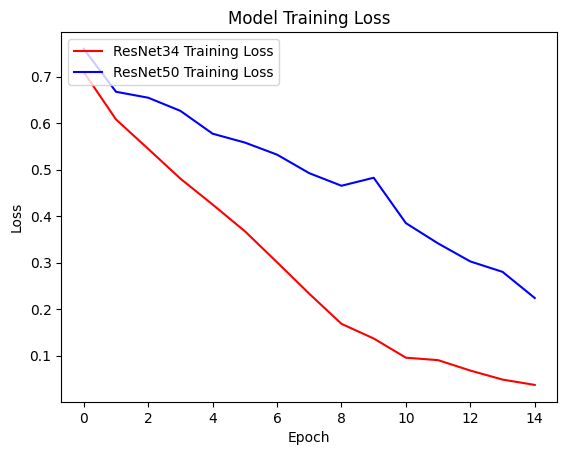

In [100]:
plt.plot(resnet34_train_losses, 'r', label="ResNet34 Training Loss")
plt.plot(resnet50_train_losses, 'b', label="ResNet50 Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

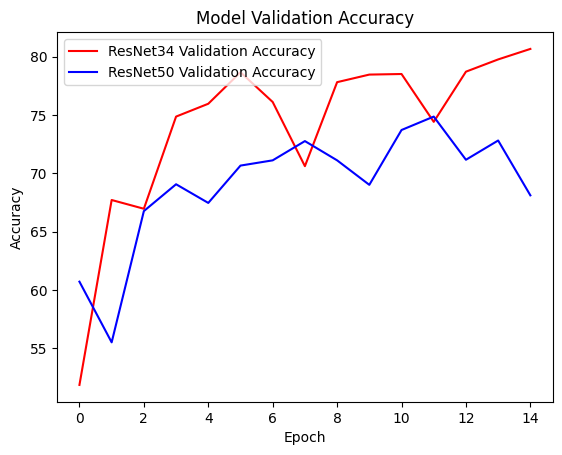

In [101]:
plt.plot(resnet34_val_accs, 'r', label="ResNet34 Validation Accuracy")
plt.plot(resnet50_val_accs, 'b', label="ResNet50 Validation Accuracy")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

---

In [102]:
# ResNet: plain block
is_skip =  False

## ResNet34: Plain 학습

In [103]:
set_seed(22)

In [104]:
model_name = "resnet34_tf"  
save_path = modelSavePath(save_dir, model_name, is_skip)

In [105]:
resnet34_Plain = ResNet(BasicBlock, [3, 4, 6, 3], 10, is_skip = is_skip ).to(device)

In [106]:
optimizer = optim.SGD(resnet34_Plain.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [107]:
resnet34_Plain_train_losses, resnet34_Plain_val_accs = train_model(
    resnet34_Plain, trainloader, testloader, criterion, optimizer, device, epochs=EPOCH, save_path = save_path 
)

Training started on cuda...
[1,    50] loss: 1.090
[1,   100] loss: 0.899
Epoch 1: Train Acc: 50.76%, Val Acc: 53.90%
[2,    50] loss: 0.688
[2,   100] loss: 0.687
Epoch 2: Train Acc: 58.26%, Val Acc: 57.60%
[3,    50] loss: 0.663
[3,   100] loss: 0.658
Epoch 3: Train Acc: 61.39%, Val Acc: 61.55%
[4,    50] loss: 0.631
[4,   100] loss: 0.628
Epoch 4: Train Acc: 65.84%, Val Acc: 64.20%
[5,    50] loss: 0.590
[5,   100] loss: 0.596
Epoch 5: Train Acc: 68.62%, Val Acc: 66.10%
[6,    50] loss: 0.567
[6,   100] loss: 0.570
Epoch 6: Train Acc: 71.24%, Val Acc: 71.45%
[7,    50] loss: 0.551
[7,   100] loss: 0.541
Epoch 7: Train Acc: 72.03%, Val Acc: 72.10%
[8,    50] loss: 0.503
[8,   100] loss: 0.504
Epoch 8: Train Acc: 74.84%, Val Acc: 72.90%
[9,    50] loss: 0.481
[9,   100] loss: 0.486
Epoch 9: Train Acc: 76.99%, Val Acc: 74.70%
[10,    50] loss: 0.448
[10,   100] loss: 0.458
Epoch 10: Train Acc: 77.91%, Val Acc: 75.40%
[11,    50] loss: 0.417
[11,   100] loss: 0.428
Epoch 11: Train Acc: 

## ResNet50: Prain 학습

In [108]:
set_seed(22)

In [109]:
model_name = "resnet50_tf"  
save_path = modelSavePath(save_dir, model_name, is_skip)

In [110]:
resnet50_Plain = ResNet(BottleneckBlock, [3, 4, 6, 3], 10,is_skip = is_skip).to(device)

In [111]:
optimizer = optim.SGD(resnet50_Plain.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [112]:
resnet50_Plain_train_losses, resnet50_Plain_val_accs = train_model(
    resnet50_Plain, trainloader, testloader, criterion, optimizer, device, epochs=EPOCH, save_path = save_path 
)

Training started on cuda...
[1,    50] loss: 0.921
[1,   100] loss: 0.807
Epoch 1: Train Acc: 51.84%, Val Acc: 50.00%
[2,    50] loss: 0.713
[2,   100] loss: 0.705
Epoch 2: Train Acc: 51.33%, Val Acc: 50.00%
[3,    50] loss: 0.696
[3,   100] loss: 0.694
Epoch 3: Train Acc: 54.15%, Val Acc: 53.60%
[4,    50] loss: 0.683
[4,   100] loss: 0.688
Epoch 4: Train Acc: 55.99%, Val Acc: 55.35%
[5,    50] loss: 0.676
[5,   100] loss: 0.676
Epoch 5: Train Acc: 57.88%, Val Acc: 52.20%
[6,    50] loss: 0.663
[6,   100] loss: 0.663
Epoch 6: Train Acc: 59.74%, Val Acc: 58.75%
[7,    50] loss: 0.666
[7,   100] loss: 0.661
Epoch 7: Train Acc: 60.34%, Val Acc: 59.25%
[8,    50] loss: 0.657
[8,   100] loss: 0.654
Epoch 8: Train Acc: 61.77%, Val Acc: 59.60%
[9,    50] loss: 0.646
[9,   100] loss: 0.650
Epoch 9: Train Acc: 61.21%, Val Acc: 61.90%
[10,    50] loss: 0.644
[10,   100] loss: 0.643
Epoch 10: Train Acc: 62.02%, Val Acc: 62.40%
[11,    50] loss: 0.630
[11,   100] loss: 0.630
Epoch 11: Train Acc: 

In [113]:
# Residual 레이어 여부
print(resnet50_Plain.stage1[0].shortcut[0].weight.grad)

None


### ResNet | Plain 실험 결과 시각화 및 성능 비교 분석

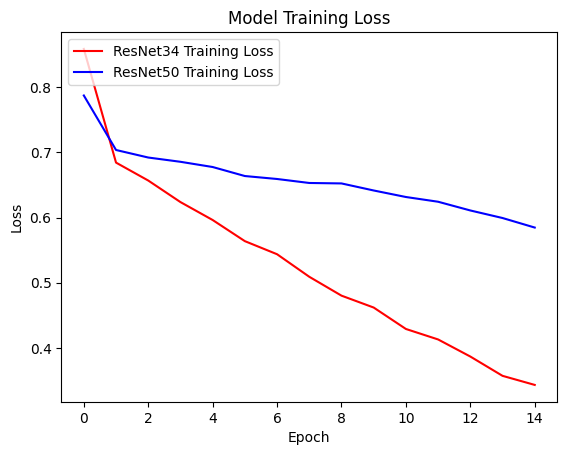

In [114]:
plt.plot(resnet34_Plain_train_losses, 'r', label="ResNet34 Training Loss")
plt.plot(resnet50_Plain_train_losses, 'b', label="ResNet50 Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

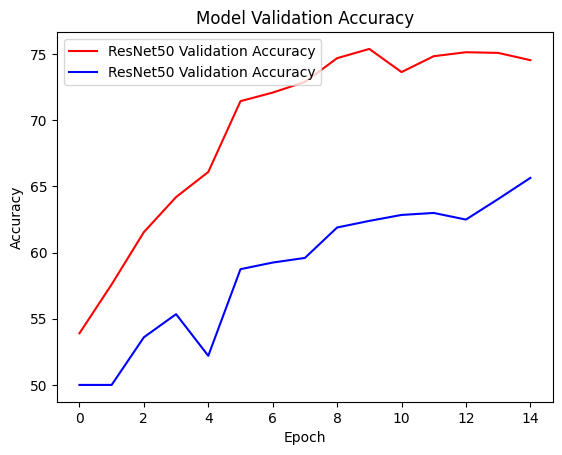

In [115]:
plt.plot(resnet34_Plain_val_accs, 'r', label="ResNet50 Validation Accuracy")
plt.plot(resnet50_Plain_val_accs, 'b', label="ResNet50 Validation Accuracy")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### ResNet | Residual&Plain 실험 결과 시각화 및 성능 비교 분석

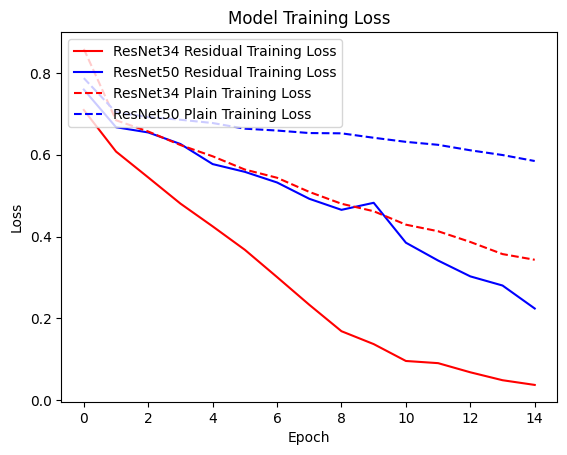

In [116]:
plt.plot(resnet34_train_losses, 'r', label="ResNet34 Residual Training Loss")
plt.plot(resnet50_train_losses, 'b', label="ResNet50 Residual Training Loss")
plt.plot(resnet34_Plain_train_losses, 'r--', label="ResNet34 Plain Training Loss")
plt.plot(resnet50_Plain_train_losses, 'b--', label="ResNet50 Plain Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

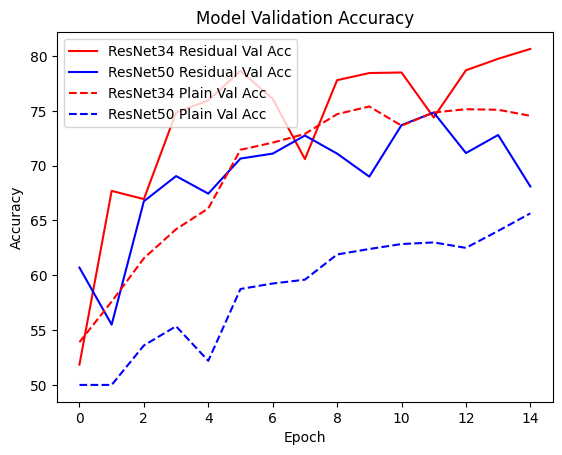

In [117]:
plt.plot(resnet34_val_accs, 'r', label="ResNet34 Residual Val Acc")
plt.plot(resnet50_val_accs, 'b', label="ResNet50 Residual Val Acc")
plt.plot(resnet34_Plain_val_accs, 'r--', label="ResNet34 Plain Val Acc")
plt.plot(resnet50_Plain_val_accs, 'b--', label="ResNet50 Plain Val Acc")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

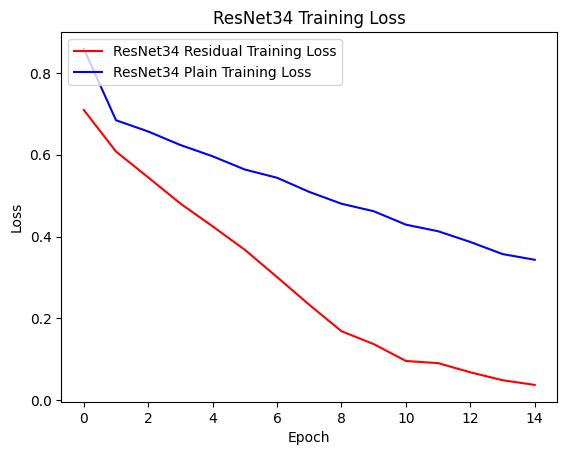

In [118]:
plt.plot(resnet34_train_losses, 'r', label="ResNet34 Residual Training Loss")
plt.plot(resnet34_Plain_train_losses, 'b', label="ResNet34 Plain Training Loss")

plt.title('ResNet34 Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

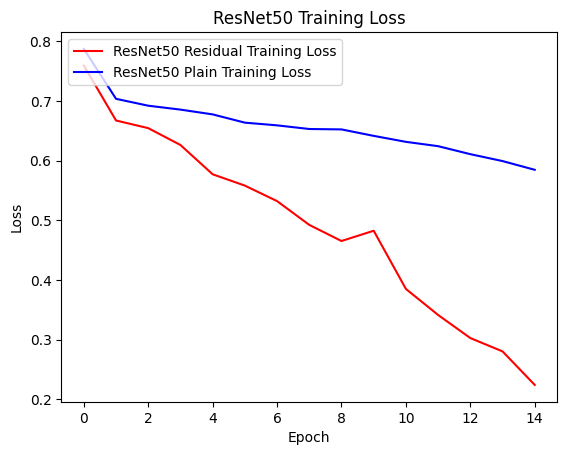

In [119]:
plt.plot(resnet50_train_losses, 'r', label="ResNet50 Residual Training Loss")
plt.plot(resnet50_Plain_train_losses, 'b', label="ResNet50 Plain Training Loss")

plt.title('ResNet50 Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

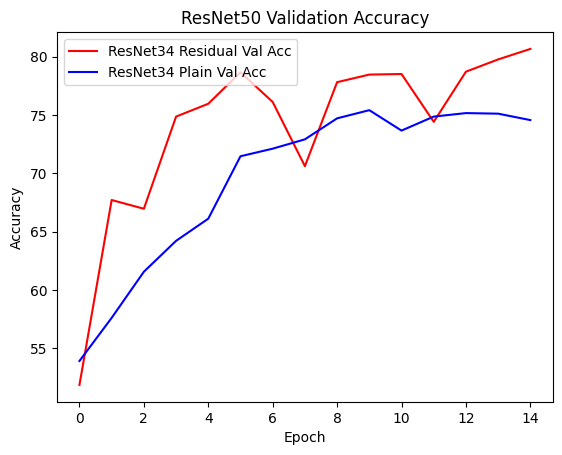

In [120]:
plt.plot(resnet34_val_accs, 'r', label="ResNet34 Residual Val Acc")
plt.plot(resnet34_Plain_val_accs, 'b', label="ResNet34 Plain Val Acc")

plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

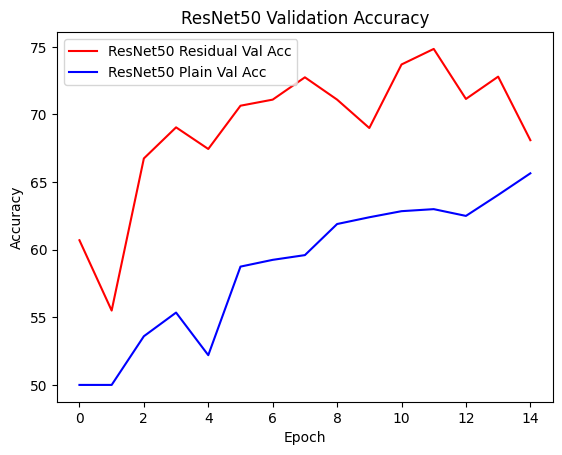

In [121]:
plt.plot(resnet50_val_accs, 'r', label="ResNet50 Residual Val Acc")
plt.plot(resnet50_Plain_val_accs, 'b', label="ResNet50 Plain Val Acc")

plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

## Confusion matrice

In [125]:
def run_final_evaluation(model, testloader, device, classes):
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []

    print("데이터 검증 중...")
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            probs = torch.softmax(outputs, dim=1) # F.softmax 대신 torch.softmax 사용 가능
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # 리스트를 numpy 배열로 변환
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # --- [결과 출력 1] Classification Report ---
    print("\n" + "="*50)
    print("1. 분류 상세 리포트")
    print("="*50)
    print(classification_report(all_labels, all_preds, target_names=classes))

    # --- [결과 출력 2] ROC-AUC Score (수정 부분) ---
    try:
        if len(classes) == 2:
            # 이진 분류일 경우: 보통 'Positive' 클래스인 인덱스 1의 확률만 전달
            auc = roc_auc_score(all_labels, all_probs[:, 1])
        else:
            # 다중 분류일 경우: OvR 방식 유지
            auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
        print(f"2. ROC-AUC Score (Overall): {auc:.4f}")
    except Exception as e:
        print(f"2. ROC-AUC 계산 중 오류 발생: {e}")

    # --- [결과 출력 3] Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

C:\Users\pe020\AppData\Local\Temp\ipykernel_6692\3369417758.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet34.load_state_dict(torch.load('./models/resnet34_tf_res

데이터 검증 중...

1. 분류 상세 리포트
              precision    recall  f1-score   support

         cat       0.77      0.88      0.82      1000
         dog       0.86      0.73      0.79      1000

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.81      0.81      0.81      2000

2. ROC-AUC Score (Overall): 0.8901


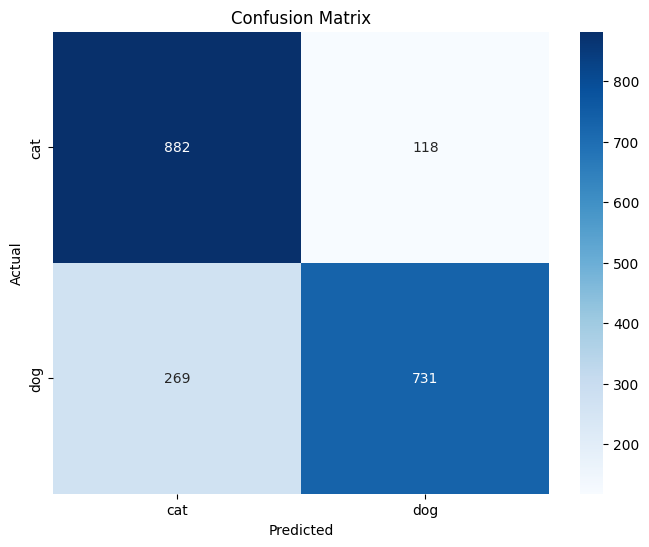

In [126]:
resnet34.load_state_dict(torch.load('./models/resnet34_tf_residual.pth', map_location=device))
resnet34.to(device)
classes = ["cat","dog"]
 
run_final_evaluation(resnet34, testloader, device, classes)

C:\Users\pe020\AppData\Local\Temp\ipykernel_6692\2618683934.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet50.load_state_dict(torch.load('./models/resnet50_tf_res

데이터 검증 중...

1. 분류 상세 리포트
              precision    recall  f1-score   support

         cat       0.81      0.48      0.60      1000
         dog       0.63      0.89      0.74      1000

    accuracy                           0.68      2000
   macro avg       0.72      0.68      0.67      2000
weighted avg       0.72      0.68      0.67      2000

2. ROC-AUC Score (Overall): 0.7990


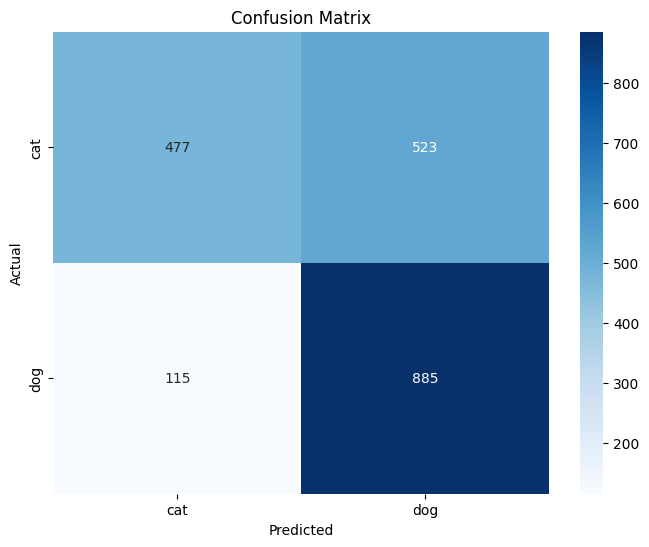

In [127]:
resnet50.load_state_dict(torch.load('./models/resnet50_tf_residual.pth', map_location=device))
resnet50.to(device)

run_final_evaluation(resnet50, testloader, device, classes)

C:\Users\pe020\AppData\Local\Temp\ipykernel_6692\2450969779.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet34_Plain.load_state_dict(torch.load('./models/resnet34_

데이터 검증 중...

1. 분류 상세 리포트
              precision    recall  f1-score   support

         cat       0.69      0.90      0.78      1000
         dog       0.85      0.60      0.70      1000

    accuracy                           0.75      2000
   macro avg       0.77      0.75      0.74      2000
weighted avg       0.77      0.75      0.74      2000

2. ROC-AUC Score (Overall): 0.8470


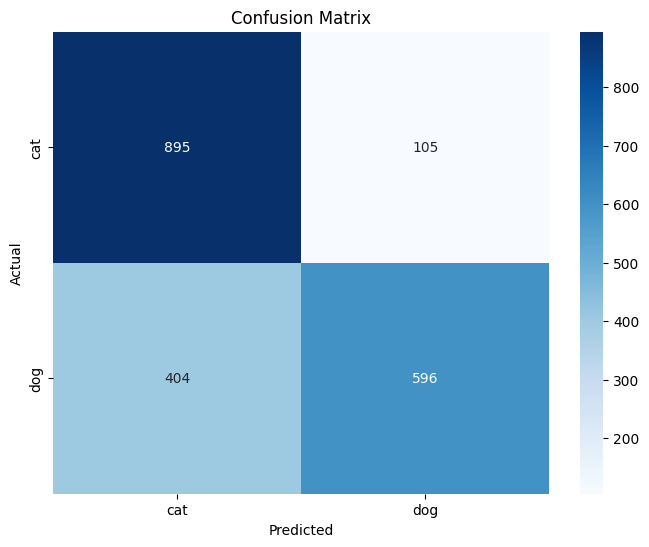

In [128]:
resnet34_Plain.load_state_dict(torch.load('./models/resnet34_tf_plain.pth', map_location=device))
resnet34_Plain.to(device)

run_final_evaluation(resnet34_Plain, testloader, device, classes)

C:\Users\pe020\AppData\Local\Temp\ipykernel_6692\829241323.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet50_Plain.load_state_dict(torch.load('./models/resnet50_t

데이터 검증 중...

1. 분류 상세 리포트
              precision    recall  f1-score   support

         cat       0.64      0.71      0.67      1000
         dog       0.68      0.60      0.64      1000

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.66      0.66      0.66      2000

2. ROC-AUC Score (Overall): 0.7260


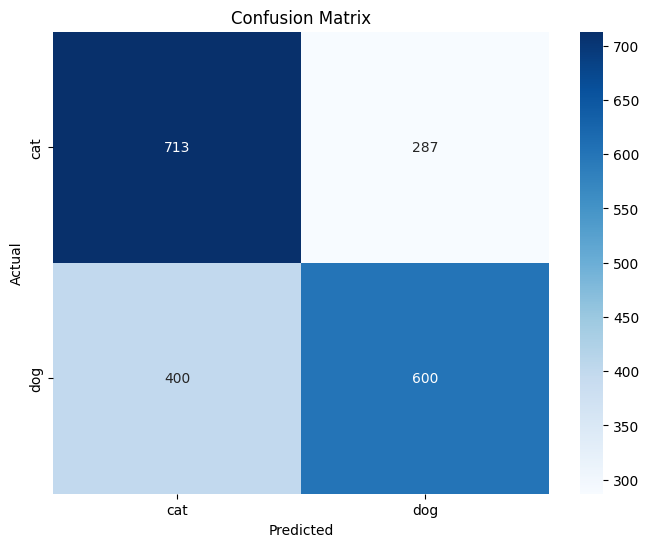

In [129]:
resnet50_Plain.load_state_dict(torch.load('./models/resnet50_tf_plain.pth', map_location=device))
resnet50_Plain.to(device)

run_final_evaluation(resnet50_Plain, testloader, device, classes)

# VGG16 vs VGG18

In [130]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [131]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [132]:
# 데이터셋을 로드하고 기본 정보를 확인해 보세요.
image, label = trainset[0]

print(f"Image shape: {image.shape}")
print(f"Label: {label}")
print(f"Number of classes: {len(trainset.classes)}")

Image shape: torch.Size([3, 32, 32])
Label: 6
Number of classes: 10


In [133]:
# 데이터의 개수도 확인해 봅시다.
train_size = torch.tensor(len(trainset))
test_size = torch.tensor(len(testset))

print(f"Train dataset size: {train_size} (Shape: {train_size.shape})")
print(f"Test dataset size: {test_size} (Shape: {test_size.shape})")

Train dataset size: 50000 (Shape: torch.Size([]))
Test dataset size: 10000 (Shape: torch.Size([]))


In [134]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 Pytorch 정규화 코드를 작성해봅시다.
transform = transforms.Compose([
    transforms.ToTensor()  # uint8 → float32 변환 + 0~1 정규화
])

In [135]:
num_classes = len(trainset.classes)
print(num_classes)

10


In [136]:
class_names = trainset.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [137]:
class_names = trainset.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [138]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))


In [139]:
def show_multiple_images(dataset, n_images=9):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    axes = axes.flatten()

    for i in range(n_images):
        ax = axes[i]
        img = imshow(images[i])
        ax.imshow(img)
        ax.set_title(f"Label: {trainset.classes[labels[i]]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

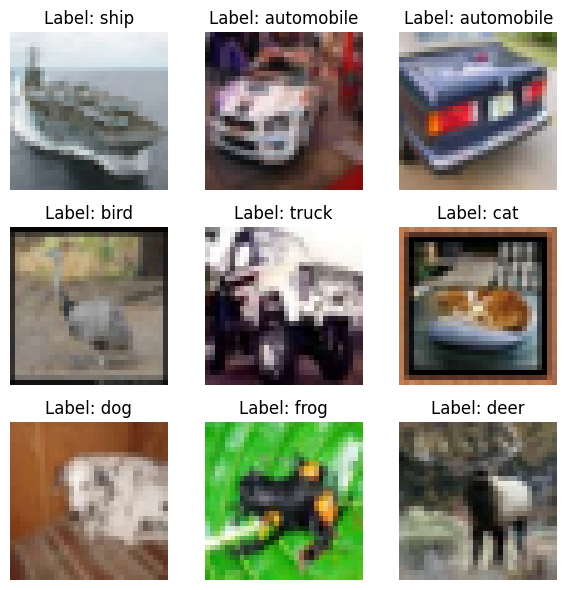

In [140]:
# 학습 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(trainloader)

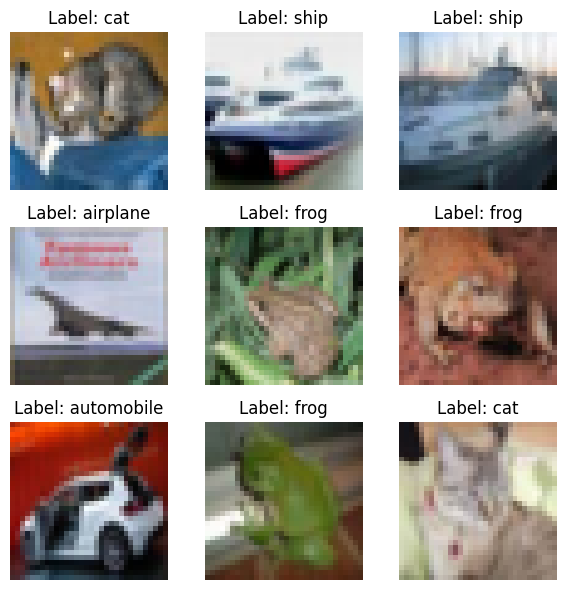

In [141]:
# 테스트 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(testloader)

In [142]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3,
                    channel=64,
                    block_num=1):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    layers = []
    in_channels = x.size(1)
    for cnn_num in range(num_cnn):
        layers.append(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=channel,
                kernel_size=3,
                stride=1,
                padding=1,
            )
        )
        layers.append(nn.ReLU(inplace=True))
        in_channels = channel

    # Max Pooling 레이어
    layers.append(
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
    )

    # Sequential으로 레이어 묶기
    block = nn.Sequential(*layers)
    return block

In [143]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()

        # VGG 블록 생성
        self.vgg_block = build_vgg_block(torch.zeros(1, 3, 32, 32))
    def forward(self, x):
        return self.vgg_block(x)

In [144]:
# 블록 1개짜리 model 생성
model = VGGNet()
print(model)

dummy_input = torch.zeros(1, 3, 32, 32)
output = model(dummy_input)
print(output.shape)

VGGNet(
  (vgg_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
torch.Size([1, 64, 16, 16])


In [145]:
# VGG 모델 자체를 생성하는 클래스입니다.
class VGG(nn.Module):
    def __init__(self, num_cnn_list=[2, 2, 3, 3, 3], channel_list=[64, 128, 256, 512, 512], num_classes=10):
        super(VGG, self).__init__()
        assert len(num_cnn_list) == len(channel_list), "num_cnn_list와 channel_list의 길이가 일치해야 합니다."

        layers = []
        in_channels = 3

        for num_cnn, out_channels in zip(num_cnn_list, channel_list):
            layers.append(self._make_vgg_block(in_channels, out_channels, num_cnn))
            in_channels = out_channels  # 다음 블록의 입력 채널을 설정

        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, num_classes)
        )

    def _make_vgg_block(self, in_channels, out_channels, num_cnn):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.ReLU(True)]
        for _ in range(num_cnn - 1):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU(True))
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # Max Pooling 추가
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [146]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.

vgg_16 = VGG()
print(vgg_16)

VGG(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [147]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = VGG(
    num_cnn_list=[2, 2, 4, 4, 4],
    channel_list=[64, 128, 256, 512, 512]
)
print(vgg_19)

VGG(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [148]:
# Q. VGG-16보다 작은 네트워크인 VGG-13을 만들어 보세요.
def build_vgg13(num_classes=10):
    return VGG(
        num_cnn_list=[2, 2, 2, 2, 2],
        channel_list=[64, 128, 256, 512, 512],
        num_classes=num_classes
    )

In [149]:
vgg_13 = build_vgg13()
print(vgg_13)

VGG(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [150]:
BATCH_SIZE = 256
EPOCH = 15

In [151]:
# CIFAR-10 데이터셋에 대해 Normalize와 Tensor 변환을 적용하는 코드
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # VGG-16 표준 정규화
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [152]:
import time

current_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_16 = torchvision.models.vgg16(pretrained=True)
vgg_16.to(device)

for param in vgg_16.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_16.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

vgg_16_train_losses = []
vgg_16_val_accuracy = []


for epoch in range(EPOCH):
    vgg_16.train()
    correct = 0
    running_loss = 0.0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg_16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i+1):.3f}")

    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct / total
    vgg_16_train_losses.append(train_loss)

    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    vgg_16.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg_16(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    vgg_16_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

print("Finished Training")
print(time.time() - current_time)

c:\Users\pe020\anaconda3\envs\ai_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pe020\anaconda3\envs\ai_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\pe020/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100.0%


[1,   100] loss: 2.861
Epoch 1: Train Accuracy: 40.30%
Epoch 1: Validation Accuracy: 63.79%
[2,   100] loss: 0.878
Epoch 2: Train Accuracy: 71.65%
Epoch 2: Validation Accuracy: 75.53%
[3,   100] loss: 0.639
Epoch 3: Train Accuracy: 78.98%
Epoch 3: Validation Accuracy: 78.86%
[4,   100] loss: 0.521
Epoch 4: Train Accuracy: 82.73%
Epoch 4: Validation Accuracy: 81.62%
[5,   100] loss: 0.456
Epoch 5: Train Accuracy: 84.54%
Epoch 5: Validation Accuracy: 81.77%
[6,   100] loss: 0.389
Epoch 6: Train Accuracy: 86.87%
Epoch 6: Validation Accuracy: 83.16%
[7,   100] loss: 0.341
Epoch 7: Train Accuracy: 88.49%
Epoch 7: Validation Accuracy: 83.92%
[8,   100] loss: 0.296
Epoch 8: Train Accuracy: 89.83%
Epoch 8: Validation Accuracy: 83.47%
[9,   100] loss: 0.264
Epoch 9: Train Accuracy: 91.06%
Epoch 9: Validation Accuracy: 84.88%
[10,   100] loss: 0.220
Epoch 10: Train Accuracy: 92.32%
Epoch 10: Validation Accuracy: 84.22%
[11,   100] loss: 0.183
Epoch 11: Train Accuracy: 93.54%
Epoch 11: Validation

In [153]:
current_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_19 = torchvision.models.vgg19(pretrained=True)
vgg_19.to(device)

for param in vgg_19.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_19.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

vgg_19_train_losses = []
vgg_19_val_accuracy = []

for epoch in range(EPOCH):
    vgg_19.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg_19(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i+1):.3f}")

    train_loss = running_loss / len(trainloader)
    vgg_19_train_losses.append(train_loss)

    train_acc = 100 * correct / total
    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    vgg_19.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg_19(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    vgg_19_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

print("Finished Training")
print(time.time() - current_time)

c:\Users\pe020\anaconda3\envs\ai_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pe020\anaconda3\envs\ai_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\pe020/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100.0%


[1,   100] loss: 2.673
Epoch 1: Train Accuracy: 45.18%
Epoch 1: Validation Accuracy: 69.66%
[2,   100] loss: 0.775
Epoch 2: Train Accuracy: 75.39%
Epoch 2: Validation Accuracy: 78.47%
[3,   100] loss: 0.559
Epoch 3: Train Accuracy: 81.55%
Epoch 3: Validation Accuracy: 80.79%
[4,   100] loss: 0.463
Epoch 4: Train Accuracy: 84.52%
Epoch 4: Validation Accuracy: 82.67%
[5,   100] loss: 0.387
Epoch 5: Train Accuracy: 86.90%
Epoch 5: Validation Accuracy: 84.58%
[6,   100] loss: 0.338
Epoch 6: Train Accuracy: 88.83%
Epoch 6: Validation Accuracy: 84.33%
[7,   100] loss: 0.290
Epoch 7: Train Accuracy: 89.97%
Epoch 7: Validation Accuracy: 85.43%
[8,   100] loss: 0.248
Epoch 8: Train Accuracy: 91.44%
Epoch 8: Validation Accuracy: 85.39%
[9,   100] loss: 0.219
Epoch 9: Train Accuracy: 92.92%
Epoch 9: Validation Accuracy: 85.84%
[10,   100] loss: 0.179
Epoch 10: Train Accuracy: 94.06%
Epoch 10: Validation Accuracy: 86.04%
[11,   100] loss: 0.153
Epoch 11: Train Accuracy: 94.80%
Epoch 11: Validation

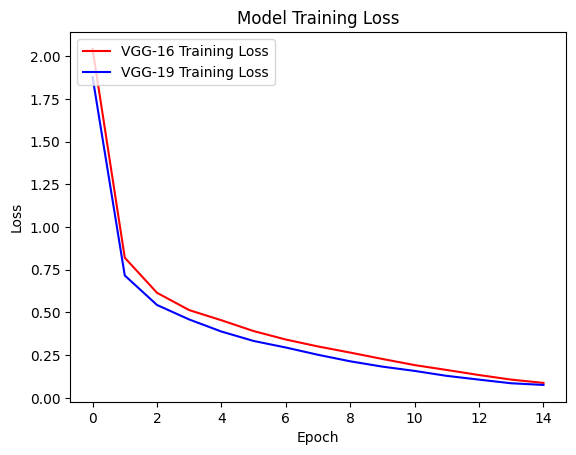

In [154]:
import matplotlib.pyplot as plt

plt.plot(vgg_16_train_losses, 'r', label="VGG-16 Training Loss")
plt.plot(vgg_19_train_losses, 'b', label="VGG-19 Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

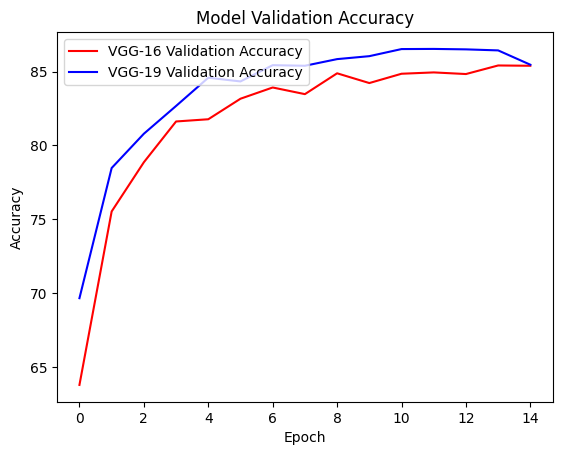

In [155]:
plt.plot(vgg_16_val_accuracy, 'r', label="VGG-16 Validation Accuracy")
plt.plot(vgg_19_val_accuracy, 'b', label="VGG-19 Validation Accuracy")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()